In [2]:
 pip install datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports Tools

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset

# Load Dataset

In [4]:
data = pd.read_csv("/content/train.csv")

# Drop Unnamed column
data = data.drop(columns=['Unnamed: 0'])
data.dropna(inplace=True)

data

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...
232069,If you don't like rock then your not going to ...,non-suicide
232070,You how you can tell i have so many friends an...,non-suicide
232071,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,The usual stuff you find hereI'm not posting t...,suicide


In [5]:
data = data.sample(n=6000,).reset_index(drop=True)
data

,text,class
0,I wish politics is about appealing to the aver...,non-suicide
1,"What am I supposed to do?I'm 17, male, and I'm...",suicide
2,i don't want to. i feel i have to. please some...,suicide
3,I need a doctorYou hear all those horror stori...,suicide
4,I don't... I don't know what to say...Someone ...,suicide
...,...,...
5995,I've had active suicidal thoughts for the past...,suicide
5996,achievement unlocked “The big sad”\n\nUnlocked...,non-suicide
5997,"I'm in Sweden, and need someone to talk to. (D...",suicide
5998,It isn't worth it anymore.If having to fight l...,suicide


# Data prerpocessing

1 Cleaning

In [6]:
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords (only needed once)
nltk.download('stopwords')

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

def clean_statement(statement):
    # Convert to lowercase
    statement = statement.lower()

    # Remove special characters (punctuation, non-alphabetic characters)
    statement = re.sub(r'[^\w\s]', '', statement)

    # Remove numbers (optional, depending on your use case)
    statement = re.sub(r'\d+', '', statement)

    # Tokenize the statement (split into words)
    words = statement.split()

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Rejoin words into a cleaned statement
    cleaned_statement = ' '.join(words)

    return cleaned_statement

# Apply the cleaning function to the 'statement' column
data['text'] = data['text'].apply(clean_statement)

data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,class
0,wish politics appealing average people rather ...,non-suicide
1,supposed doim male im currently senior highsch...,suicide
2,dont want feel please somebody stop meplease,suicide
3,need doctoryou hear horror stories going hospi...,suicide
4,dont dont know saysomeone please talk,suicide
...,...,...
5995,ive active suicidal thoughts past days every d...,suicide
5996,achievement unlocked big sad unlocked sad cant...,non-suicide
5997,im sweden need someone talk need swedishi dont...,suicide
5998,isnt worth anymoreif fight like every day livi...,suicide


2 balance dataset

In [7]:
data['class'].value_counts()

,count
class,
suicide,3089
non-suicide,2911


In [8]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Create an instance of RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Define features (X) and target (y)
X = data.drop(columns=['class'])
y = data['class']

# Perform oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combine the oversampled features and target back into a DataFrame
data = pd.concat([X_resampled, y_resampled], axis=1)

# Check the new class distribution
print(data['class'].value_counts())


class
non-suicide    3089
suicide        3089
Name: count, dtype: int64


 3 Encoding *Status*

In [9]:
# Label encoding for 'status' column
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['class'])

# Train Test Split

In [10]:
# Split data into train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(data['text'], data['label'], test_size=0.2)

In [11]:
max([len(text) for text in data['text']])

14631

# Tokenization

In [12]:
# Tokenization using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=200)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=200)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
# Convert to Dataset format
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': test_labels.tolist()})\



# Fine Tuning Bert

In [14]:
len(label_encoder.classes_)

2

In [17]:
# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Set training arguments with improvements
training_args = TrainingArguments(
    output_dir="./results",          # Output directory for results
    eval_strategy="epoch",     # Evaluate once per epoch
    save_strategy="epoch",          # Save model at the end of each epoch to match evaluation strategy
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=5,              # Increase number of epochs
    weight_decay=0.01,               # Strength of weight decay
    logging_dir="./logs",            # Directory for logging
    logging_steps=10,                # Log every 10 steps
    lr_scheduler_type="linear",      # Use linear learning rate scheduler with warmup
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    load_best_model_at_end=True,     # Load the best model at the end of training
    metric_for_best_model="eval_loss", # Monitor eval loss to determine the best model
    save_total_limit=3,              # Limit the number of checkpoints to save
    gradient_accumulation_steps=2    # Simulate larger batch size if GPU memory is limited
)
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Fine-tuning the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sanjaypavi97 (sanjaypavi97-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.339200,0.321283
2,0.261300,0.142118
3,0.196300,0.110939
4,0.040900,0.133192
5,0.026500,0.159928


TrainOutput(global_step=775, training_loss=0.19691201156666202, metrics={'train_runtime': 1006.6652, 'train_samples_per_second': 24.546, 'train_steps_per_second': 0.77, 'total_flos': 2539638350760000.0, 'train_loss': 0.19691201156666202, 'epoch': 5.0})

#  Model Evaluation


              precision    recall  f1-score   support

 non-suicide       0.97      0.96      0.96       608
     suicide       0.96      0.97      0.97       628

    accuracy                           0.96      1236
   macro avg       0.96      0.96      0.96      1236
weighted avg       0.96      0.96      0.96      1236



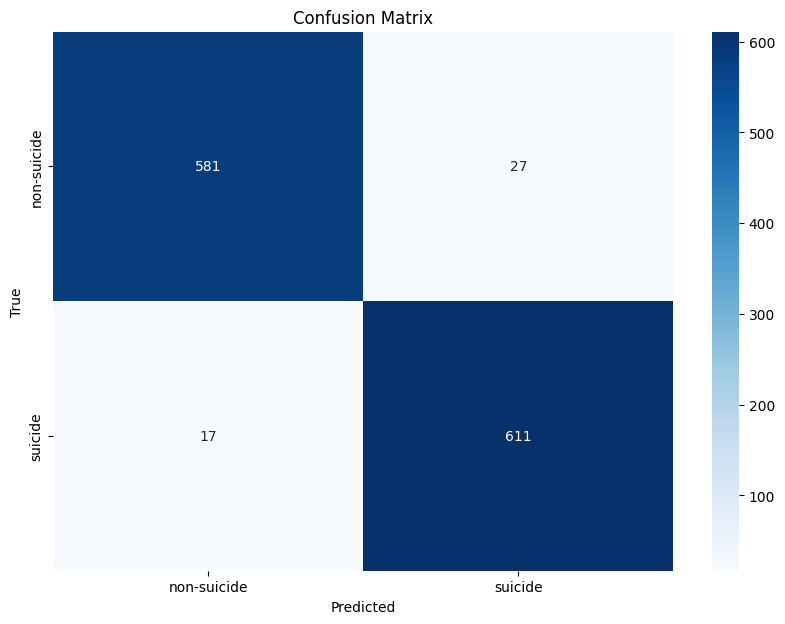

In [18]:
# Predictions
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Classification Report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save and Load Model and Tokenizer

In [19]:
# Save the trained model and tokenizer
trainer.save_model("saved_mental_status_bert")  # Save the model to the specified directory
tokenizer.save_pretrained("saved_mental_status_bert")  # Save the tokenizer


import pickle

pickle.dump(label_encoder, open('label_encoder.pkl', 'wb'))

In [20]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer from the saved paths
model = AutoModelForSequenceClassification.from_pretrained("saved_mental_status_bert")
tokenizer = AutoTokenizer.from_pretrained("saved_mental_status_bert")

label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))

# Detection System

In [21]:
# Detection System (Example)
def detect_anxiety(text):
    cleaned_text = clean_statement(text)
    inputs = tokenizer(cleaned_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

# Test detection system with a mixture of normal, anxiety, bipolar, depression, suicide, etc.
sample_texts = [
    "I feel perfectly fine today, nothing to worry about.",
    "I can't stop thinking about what will happen if things go wrong.",
    "Lately, I've been on a high, feeling like I can do anything!",
    "I'm so sad, I just can't seem to get out of bed anymore.",
    "I'm constantly thinking about how much better everyone else is doing than me.",
    "I don't think I can keep going, everything feels so hopeless.",
    "I had a really good day, spent some time with my friends.",
    "I'm overwhelmed by the idea that I might lose everything.",
    "I feel like nothing matters anymore, I just want to give up.",
    "I'm okay today, but sometimes I get really anxious for no reason."
]

# Assuming the detect_anxiety function is already defined and takes a sentence as input
for text in sample_texts:
    predicted_class = detect_anxiety(text)
    print(f"Sentence: {text}\nPredicted class: {predicted_class}\n")


Sentence: I feel perfectly fine today, nothing to worry about.
Predicted class: non-suicide

Sentence: I can't stop thinking about what will happen if things go wrong.
Predicted class: non-suicide

Sentence: Lately, I've been on a high, feeling like I can do anything!
Predicted class: non-suicide

Sentence: I'm so sad, I just can't seem to get out of bed anymore.
Predicted class: non-suicide

Sentence: I'm constantly thinking about how much better everyone else is doing than me.
Predicted class: non-suicide

Sentence: I don't think I can keep going, everything feels so hopeless.
Predicted class: suicide

Sentence: I had a really good day, spent some time with my friends.
Predicted class: non-suicide

Sentence: I'm overwhelmed by the idea that I might lose everything.
Predicted class: non-suicide

Sentence: I feel like nothing matters anymore, I just want to give up.
Predicted class: non-suicide

Sentence: I'm okay today, but sometimes I get really anxious for no reason.
Predicted class

# Downlaod Model To Your PC Directly

In [22]:
import shutil
from google.colab import files

# Step 1: Save the trained model and tokenizer
model_save_path = "saved_mental_status_bert"  # Path to save the trained model
tokenizer_save_path = "saved_mental_status_bert"  # Path to save the tokenizer

# Save the model and tokenizer
trainer.save_model(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

# Step 2: Create a zip file containing the saved model and tokenizer using shutil
zip_file_path = "saved_mental_status_bert"  # Path for the zip file without extension

# Create a zip archive of the directories
shutil.make_archive(zip_file_path, 'zip', root_dir='saved_mental_status_bert', base_dir='')

# Step 3: Provide a download link to the zip file
files.download(f"{zip_file_path}.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>